# Идентификация сообщений, передаваемых по зашумленному каналу связи

# 1. Последовательная передача одинаковых сообщений

## 1.1. Определение переданного сообщения

### Исходный алфавит

In [1]:
def get_alphabet(filename):
    """Считать алфавит из файла"""
    alphabet = {}
    with open(filename, encoding='utf8') as f:
        content = f.readlines()
        content = [x.rstrip().split('\t') for x in content]
        for pair in content:
            alphabet[pair[0]] = pair[1]
    return alphabet


def get_char(alphabet: dict, code: str):
    """Найти символ по его двоичному коду"""
    for key, value in alphabet.items():
        if value == code:
            return key


def get_sorted_keys(alphabet: dict):
    """Получить алфавит, отсортерованный по двоичному коду символов"""
    sorted_values = sorted(alphabet.values())
    sorted_keys = []
    for value in sorted_values:
        sorted_keys.append(get_char(alphabet, value))
    return sorted_keys


In [2]:
alph = get_alphabet('alphabet.txt')
print(alph)

{')': '1010101', '2': '0000010', '!': '1001110', ' ': '1010110', 'Ъ': '0100111', 'Г': '0001101', '7': '0000111', 'Р': '0011011', 'Я': '0101010', 'й': '0110101', 'у': '0111111', 'А': '0001010', 'Ж': '0010001', 'О': '0011001', 'н': '0111001', 'Д': '0001110', 'Щ': '0100100', 'ц': '1000010', 'ж': '0110010', 'и': '0110100', 'ь': '1000110', 'Ч': '0100010', 'ч': '1000011', 'Ё': '0010000', 'Ф': '0011111', 'с': '0111101', 'П': '0011010', 'л': '0110111', 'о': '0111010', '_': '1010010', ',': '1001101', 'м': '0111000', 'Э': '0101000', 'я': '1001011', 'ъ': '1001000', 'И': '0010011', 'Т': '0011101', '№': '1010011', 'р': '0111100', 'г': '0101110', 'Ю': '0101001', 'х': '1000001', 'Л': '0010110', 'Ш': '0100011', 'в': '0101101', 'Ы': '0100110', '(': '1010100', '.': '1001100', '-': '1010001', '5': '0000101', 'э': '1001001', 'Н': '0011000', 'Ь': '0100101', 'С': '0011100', 'т': '0111110', 'а': '0101011', 'К': '0010101', 'п': '0111011', 'У': '0011110', 'М': '0010111', '9': '0001001', 'ш': '1000100', '1': '0

Словарь априорных вероятностей:

In [3]:
priori = alph.copy()
n = len(alph)
p = 1 / n
for key, value in priori.items():
    priori[key] = p


Функция, находящая максимальное значение в словаре

In [4]:
def find_max(d: dict):
    """Найти в словаре ключ с максимальным значением"""
    return max(d, key=d.get)


### Входные данные

In [5]:
with open('input.txt', encoding='utf8') as f:
    content = f.readlines()


Колличество букв в каждом сообщении равно $s$:

In [6]:
s = int(content[0].split(': ')[1])
print('s = {s}'.format(s=s))


s = 222


Вероятность искажения каждого отдельного символа (бита) равна $q$, вероятность правильной передачи $p = 1 - q$:

In [7]:
q = float(content[2].split(': ')[1])
p = 1 - q
print('p = {p}, q = {q}'.format(p=p, q=q))


p = 0.832, q = 0.168


Колличествно сообщений (посылок) равно $m$:

In [8]:
m = int(content[3].split(': ')[1])
print('m = {m}'.format(m=m))


m = 18


In [9]:
char_num = 7 # номер буквы, которую будем исследовать в заданиях 1.2 и 2.2

### Функции для работы с вероятностями

In [10]:
import math

q = 0.168

def find_prob(x: str, y: str):
    """Найти вероятность p(y|x)"""
    assert len(x) == len(y)
    res = 1
    for i in range(len(x)):
        res = res * (1 - q if x[i] == y[i] else q)
    return res

def find_message_prob(x: dict, x_when_y: dict):
    """Найти вероятность p(y)"""
    res = 0
    for char in x_when_y.keys():
        res = res + x_when_y[char] * x[char]
    return res

def find_posterior_probs(alph: dict, x: dict, y: str):
    """Найти вероятность p(x|y)"""
    x_when_y = alph.copy()
    for char in x_when_y.keys():
        x_when_y[char] = find_prob(alph[char], y)
    prob_y = find_message_prob(x, x_when_y)
    x_post = x.copy()
    for char in x.keys():
        x_post[char] = x_when_y[char] * x[char] / prob_y
    return x_post

def find_entropy(x: dict):
    """Найти энтропию H(X)"""
    res = 0
    for key, value in x.items():
        res = res + value * math.log2(value)
    return -res

def find_cond_entropy(alph: dict, x: dict, y: str):
    """Найти условную энтропию H(X|y)"""
    x_when_y = find_posterior_probs(alph, x, y)
    res = 0
    for key, value in x.items():
        res = res + x_when_y[key] * math.log2(x_when_y[key])
    return -res

def find_avg_entropy(alph: dict, x: dict, y: list):
    """Найти среднюю условную энтропию H(X|Y)"""
    res = 0
    for yi in y:
        x_when_y = find_posterior_probs(alph, x, yi)
        res = res + find_message_prob(x, x_when_y) * find_cond_entropy(alph, x, yi)
    return res

def find_info(alph: dict, x: dict, y: str):
    """Найти количество информации I(X:y)"""
    res = 0
    post = find_posterior_probs(alph, x, y)
    for char in x.keys():
        res = res + post[char] * math.log2(x[char])
    return -res - find_cond_entropy(alph, x, y)

def find_avg_info(alph: dict, x: dict, y: list):
    """Найти среднее количество информации I(X:Y)"""
    return find_entropy(x) - find_avg_entropy(alph, x, y)


### Все символы равновероятны

In [11]:
messages = []

for i in range(m):
    codes = content[i + 4].split(': ')[1].rstrip().split(' ')
    messages.append(codes)


In [12]:
chars = []  # вероятности появления каждого j-ого символа после i-ого сообщения
entropies = []  # значения энтропий каждого j-ого символа после i-ого сообщения
infos = []  # значения кол-ва информации об j-ом символе после i-ого сообщения

char_array = []  # инициализируем априорными вероятностями
for j in range(s):
    char = priori.copy()
    char_array.append(char)
chars.append(char_array)

for i in range(m):  # для каждого сообщения

    entropies_array = []
    info_array = []

    for j in range(s):  # для каждой буквы в сообщении
        entropies_array.append(find_cond_entropy(alph, chars[i][j], messages[i][j]))
        info_array.append(find_info(alph, chars[i][j], messages[i][j]))
        chars[i][j] = find_posterior_probs(alph, chars[i][j], messages[i][j])

    entropies.append(entropies_array)
    infos.append(info_array)

    if i != m - 1:  # априорное для следующего = апостериорное для текущего
        char_array = []
        for j in range(s):
            char = chars[i][j].copy()
            char_array.append(char)
        chars.append(char_array)


In [13]:
for i in range(m):
    print(i + 1, end=': ')
    for j in range(s):
        max_char = find_max(chars[i][j])
        print(max_char, end='')
    print()


1: 8:ЛДьэчимв 4зГЩр)ПизьдпПзж:ж235ц1Ё ) вжчННжпк ,кБНпыпЯлдчт_заяит пЯ гХНоиб(вевЯчтЮосйиёцуЗНитЩтисШ (ирелЬаМр3чЦТзШЬо,тча. Ял!ЛФтжгЯ(ЯоПсебмеЯТ! про(йЩат6(хУЙ РммвкеифКо ззЬа:и(й?ннелЯр.!А№ц(рЯсяЁрн7х када-ж2!кА(и3елаю эдЗ.
2: Я,(!ьэчинв 4ШТЩмчьйШ ЪРоЖжЕ_27Ьъ5Ё :ЛвЯШмУжнжьвйРма!пАЪЪ№У жЯ!итьпо_гЭориЩ виуо№УмайлиЖцуЛЁигиоисЮ )ймик7Ш ТчяеТЖШвЯ,ицаш Ай! ,ЫоДо ооПребниЯс! прПрифатД)фДи пПжвтейш)н зоЪаяи и ОсжуЧр!!3чШ рЯсчЁтнМх еадЯЭжА!ЛЭ)с3жлаю(,уП,
3: !, ДьэчЛмв 4ауЩм, изшгттпз:_23Ьъ5Зь, вЧШмжжно вкорпьпЯлучт жачет по№геориЩьвжрЯятнойтеЖМуЛЗеЫЩтисЮ (имикла рБяЦсзаво,ича. Азя ,тоДо потрертегс: пробе4ать)хти птмвтейфй? зРдпчи к(суелЯть!2-ШЛрЯсчетн7х жадЮния. Я(сБжлаю ,дП.
4: гГ(ДьячЛов ВадЩм: ил(гртпз:_235ъ4_!, вжШмжжуо влоро полу№у жачетьпо теориЩьЮжрЯятнойуеЖ уЛПикЩуинЮ )ймикйа СБяХсйавП,ича, Для ,того потржЩтегс: прпгешать)хуи птмстейшй? зБЫпчи к сселЯть!2-ШЛрЯТчетныщ жавЮния. а с3жлаю(,уПД
5: г, ДьячЛов 4ауим, из гттпз: 23Ь81_6, вжамжжно вкоро получу зачет по теорииьЮжроятнойтеК у Пик

In [14]:
import plots

for i in range(m):  # для каждого сообщения
    curr = chars[i][char_num]

    title = 'Распределение вероятностей {0}-ой буквы сообщения после {1}-ой посылки (равновероятные)'.format(char_num, i + 1)
    save = './../pics/uniform{0}.png'.format(i + 1)
    plots.draw_distribution(get_sorted_keys(alph), curr, title, show=False, save=save)


### Вероятности задаются исходя из частоты встречания букв в русском языке

In [15]:
with open('frequencies.txt', encoding='utf8') as f:
    content = f.readlines()
    frequncies = {}
    content = [x.rstrip().split('\t') for x in content] 
    for pair in content:
        frequncies[pair[0]] = float(pair[1])
        
print(frequncies)


{'и': 7.45, 'з': 1.81, 'ц': 0.52, 'в': 4.19, 'ю': 1.03, 'е': 8.1, 'ч': 1.27, 'т': 6.3, 'й': 1.31, 'у': 2.9, 'с': 5.45, 'ф': 0.4, 'э': 0.17, 'л': 4.32, 'б': 1.51, 'р': 5.53, 'ь': 1.9, 'н': 6.35, 'м': 3.29, 'к': 3.47, 'а': 8.66, 'ъ': 0.04, 'я': 2.22, 'д': 2.56, 'ё': 0.14, 'ш': 0.77, 'щ': 0.49, 'п': 3.35, 'г': 1.41, 'ы': 2.11, 'о': 9.28, 'ж': 0.78, 'х': 0.92}


In [16]:
def get_frequency(char: str):
    """Получить вероятноость встречания символа"""
    assert len(char) == 1
    char = char.lower()
    if char in frequncies.keys():
        return len(frequncies) * priori[char] * frequncies[char] / sum(frequncies.values())
    else:
        return priori[char]


In [17]:
priori_weight = priori.copy()
for key in priori_weight.keys():
    priori_weight[key] = get_frequency(key)
    
for key in get_sorted_keys(alph):    
    print('p(\'{0}\') = {1}'.format(key, '{0:.4f}'.format(priori_weight[key])), end=',\t')
print()
print('Sum = ' + str(sum(priori_weight.values())))


p('0') = 0.0115,	p('1') = 0.0115,	p('2') = 0.0115,	p('3') = 0.0115,	p('4') = 0.0115,	p('5') = 0.0115,	p('6') = 0.0115,	p('7') = 0.0115,	p('8') = 0.0115,	p('9') = 0.0115,	p('А') = 0.0328,	p('Б') = 0.0057,	p('В') = 0.0159,	p('Г') = 0.0053,	p('Д') = 0.0097,	p('Е') = 0.0307,	p('Ё') = 0.0005,	p('Ж') = 0.0030,	p('З') = 0.0069,	p('И') = 0.0283,	p('Й') = 0.0050,	p('К') = 0.0132,	p('Л') = 0.0164,	p('М') = 0.0125,	p('Н') = 0.0241,	p('О') = 0.0352,	p('П') = 0.0127,	p('Р') = 0.0210,	p('С') = 0.0207,	p('Т') = 0.0239,	p('У') = 0.0110,	p('Ф') = 0.0015,	p('Х') = 0.0035,	p('Ц') = 0.0020,	p('Ч') = 0.0048,	p('Ш') = 0.0029,	p('Щ') = 0.0019,	p('Ь') = 0.0072,	p('Ы') = 0.0080,	p('Ъ') = 0.0002,	p('Э') = 0.0006,	p('Ю') = 0.0039,	p('Я') = 0.0084,	p('а') = 0.0328,	p('б') = 0.0057,	p('в') = 0.0159,	p('г') = 0.0053,	p('д') = 0.0097,	p('е') = 0.0307,	p('ё') = 0.0005,	p('ж') = 0.0030,	p('з') = 0.0069,	p('и') = 0.0283,	p('й') = 0.0050,	p('к') = 0.0132,	p('л') = 0.0164,	p('м') = 0.0125,	p('н') = 0.0241,	p('о') = 0.035

In [18]:
chars_weight = []  # вероятности появления каждого j-ого символа после i-ого сообщения
entropies_weight = []  # значения энтропий каждого j-ого символа после i-ого сообщения
infos_weight = []  # значения кол-ва информации об j-ом символе после i-ого сообщения

char_array = []  # инициализируем априорными вероятностями
for j in range(s):
    char = priori_weight.copy()
    char_array.append(char)
chars_weight.append(char_array)

for i in range(m):  # для каждого сообщения

    entropies_array = []
    info_array = []

    for j in range(s):  # для каждой буквы в сообщении
        entropies_array.append(find_cond_entropy(alph, chars_weight[i][j], messages[i][j]))
        info_array.append(find_info(alph, chars_weight[i][j], messages[i][j]))
        chars_weight[i][j] = find_posterior_probs(alph, chars_weight[i][j], messages[i][j])

    entropies_weight.append(entropies_array)
    infos_weight.append(info_array)

    if i != m - 1:  # априорное для следующего = постериорное для текущего
        char_array = []
        for j in range(s):
            char = chars_weight[i][j].copy()
            char_array.append(char)
        chars_weight.append(char_array)


In [19]:
for i in range(m):
    print(i + 1, end=': ')
    for j in range(s):
        max_char = find_max(chars_weight[i][j])
        print(max_char, end='')
    print()


1: 8:ЛДь,чимв 4зЕирТПизьдпПзо:_23521е Т воаНН_пк вкАНпыпЯлдчт_заяит пЯ геНоиб(вевЯчтаосиие2уЗНититиса СирелЬаМр3ч1ТзаЬо,тча. Ял!Л:тогЯ(ЯоПсебмеЯТ! проСииат6(хУикРммвкеи0Ко ззЬа:и(и?ннелЯр.!А№Ч(рЯсяерн7х када-_2!кА(и3елаА ,дЗ.
2: А,ЛА6э3инв ВаЕХр-_изЛдОоозЕ_275А5_ :ЛвоШНо_но виоНаАпАлл№т за!ет по_теооии вето№тноТЕеЖИуЛНетиоиса )иреллаЛТ3:еТИаво,очаВ Ал:Л:тоДо ооореиоеоТ: проре4ат!)-текОоовтеи.ио(зова:и иеОоелЯт!!А-еЛрЯТяетнИх еадАееА.тА)и3елаю ,тП,
3: !, Дь,чЛмв 4ауим, изшгттпз:_23Ь85Зь, вЧаможно вкорпьпЯлучт еачет по георииьверЯятнойтеЖМуЛЗеЫитиса (имикла рЕяЦсзавовича. Азя ,тоДо потрертегс: пробе4ать)хти птмвтеифие зРдпчи к(суелЯть!2-ШЛрЯсчетн7х оадания. Я(саелаю ,дП.
4: гЕ Д!ячЛов Вауим, ил Ыттпз:_23585_!, вЧамжжно влоро полу№т зачет по теории вероятностеК уЛПекЩтина Кирилла ряяХсИавовича, АляЛ,тоДо потреитетс: проте4ат6)хти птостейшие задачи и сселАть!2-3ЛраТчетн7х завания. а саелаю ,тПВ
5: г, ДьячЛов 4ауим, из гттпз: 23Ь81_6, воаможно вкоро получу зачет по теорииьЮероятнойтеК у Пик

In [20]:
for i in range(m):  # для каждого сообщения
    curr = chars_weight[i][char_num]

    title = 'Распределение вероятностей {0}-ой буквы сообщения после {1}-ой посылки (взвешенные вероятности)'.format(char_num, i + 1)
    save = './../pics/weighted{0}.png'.format(i + 1)
    plots.draw_distribution(get_sorted_keys(alph), curr, title, show=False, save=save)


Из результатов видно, что в ситуации, когда вероятности задаются ихсодя из частоты встречания букв в русском языке, зашумленное сообщение было распознано немного быстрее.

## 1.2. Расчет энтропии и количества информации

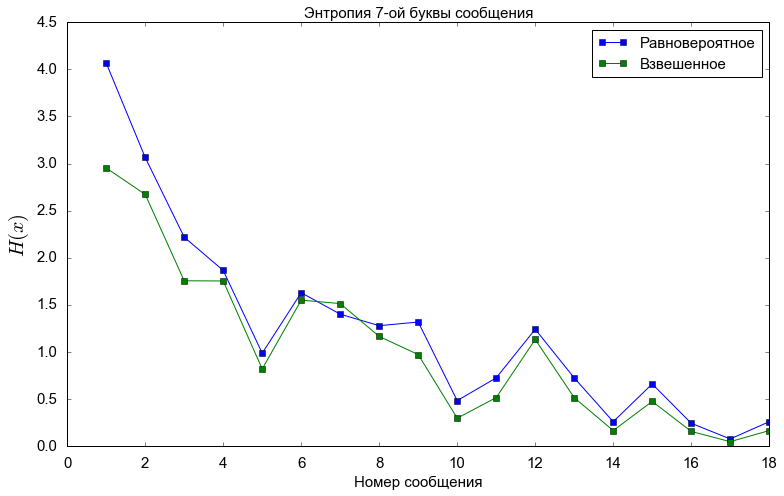

In [21]:
x = range(1, m+1)
h_u = []
h_w = []

for i in range(m):
    h_u.append(entropies[i][char_num])
    h_w.append(entropies_weight[i][char_num])
    
plots.draw_entropy(x, h_u, h_w, title='Энтропия {0}-ой буквы сообщения'.format(char_num, i + 1), save='./../pics/entropy.png')


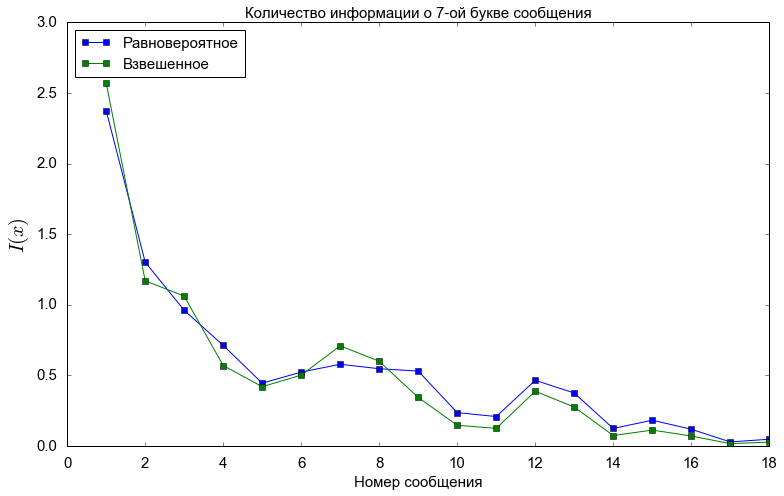

In [22]:
x = range(1, m+1)
i_u = []
i_w = []
    
for i in range(m):
    i_u.append(infos[i][char_num])
    i_w.append(infos_weight[i][char_num])
    
plots.draw_info(x, i_u, i_w, title='Количество информации о {0}-ой букве сообщения'.format(char_num, i + 1), save='./../pics/infos.png')


Средняя условная энтропия $H(X|Y)$ и среднее количество информации $I(X|Y)$: 

In [23]:
msgs = []
x_u = []
x_w = []
for i in range(m):
    x_u.append(chars[i][char_num])
    x_w.append(chars_weight[i][char_num])
    msgs.append(messages[i][char_num])
    
print('H_uniform(X|Y) = {h}'.format(h=find_avg_entropy(alph, priori, msgs)))
print('I_uniform(X:Y) = {i}'.format(i=find_avg_info(alph, priori, msgs)))
print('H_weighted(X|Y) = {h}'.format(h=find_avg_entropy(alph, priori_weight, msgs)))
print('I_weighted(X:Y) = {i}'.format(i=find_avg_info(alph, priori_weight, msgs)))

H_uniform(X|Y) = 0.8616924025101425
I_uniform(X:Y) = 5.58125109333858
H_weighted(X|Y) = 1.235442211083206
I_weighted(X:Y) = 4.794408292979066


# Часть 2 Передача сообщения путем многократного дублирования

## Все символы равновероятны

In [24]:
long_alph = alph.copy()

for key in long_alph.keys():
    long_alph[key] = long_alph[key] * 18

In [25]:
long_chars = []  # вероятности появления каждого j-ого символа инициализируем априорными вероятностями
long_entropies = []  # значения энтропий каждого j-ого символа
long_infos = []  # значения кол-ва информации об j-ом символе
for j in range(s):
    char = priori.copy()
    long_chars.append(char)

for j in range(s):  # для каждой буквы в сообщении
    long_char = ''
    for i in range(m):  # для каждого сообщения
        long_char = long_char + messages[i][j]
    long_entropies.append(find_cond_entropy(long_alph, long_chars[j], long_char))
    long_infos.append(find_info(long_alph, long_chars[j], long_char))
    long_chars[j] = find_posterior_probs(long_alph, long_chars[j], long_char)

In [26]:
for j in range(s):
    max_char = find_max(long_chars[j])
    print(max_char, end='')
print()

Я, Дьячтов Вадим, из группы 23501_4, возможно скоро получу зачет по теории вероятностей у Никитина Кирилла Вячеславовича. Для этого потребуется прорешать эти простейшие задачи и сделать 2-3 расчетных задания. Я сделаю это!


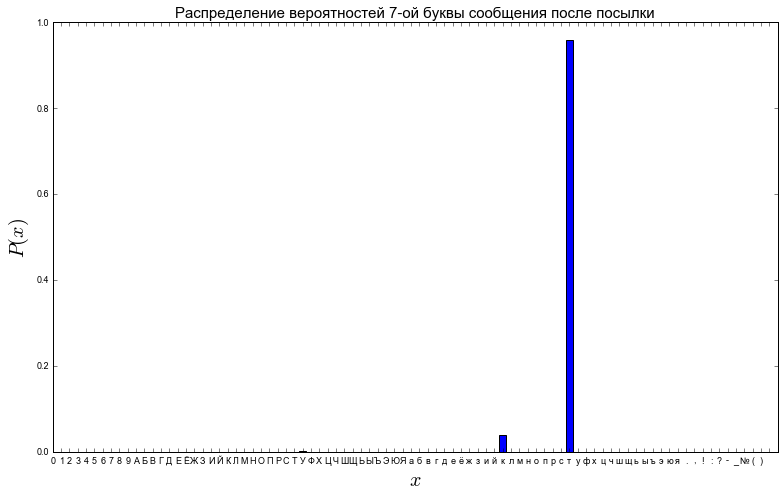

In [27]:
curr = long_chars[char_num]
    
title = 'Распределение вероятностей {0}-ой буквы сообщения после посылки'.format(char_num)
save = './../pics/long_uniform.png'
plots.draw_distribution(get_sorted_keys(long_alph), curr, title, show=True, save=save)


#### Вероятности задаются исходя из частоты встречания букв в русском языке

In [28]:
long_chars_weight = []  # вероятности появления каждого j-ого символа инициализируем априорными вероятностями
long_entropies_weight = []  # значения энтропий каждого j-ого символа
long_infos_weight = []  # значения кол-ва информации об j-ом символе
for j in range(s):
    char = priori_weight.copy()
    long_chars_weight.append(char)

for j in range(s):  # для каждой буквы в сообщении
    long_char = ''
    for i in range(m):  # для каждого сообщения
        long_char = long_char + messages[i][j]
    long_entropies_weight.append(find_cond_entropy(long_alph, long_chars_weight[j], long_char))
    long_infos_weight.append(find_info(long_alph, long_chars_weight[j], long_char))
    long_chars_weight[j] = find_posterior_probs(long_alph, long_chars_weight[j], long_char)

In [29]:
for j in range(s):
    max_char = find_max(long_chars[j])
    print(max_char, end='')
print()

Я, Дьячтов Вадим, из группы 23501_4, возможно скоро получу зачет по теории вероятностей у Никитина Кирилла Вячеславовича. Для этого потребуется прорешать эти простейшие задачи и сделать 2-3 расчетных задания. Я сделаю это!


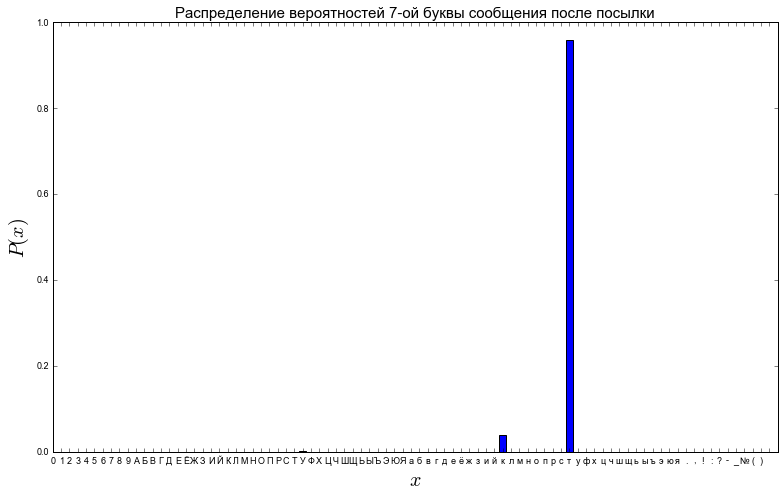

In [30]:
curr = long_chars[char_num]

title = 'Распределение вероятностей {0}-ой буквы сообщения после посылки'.format(char_num)
save = './../pics/long_uniform_weighted.png'
plots.draw_distribution(get_sorted_keys(long_alph), curr, title, show=True, save=save)

## 2.2. Расчет энтропии и количества информации

In [31]:
print('H_uniform(X|y_{i}) = {h}'.format(i=char_num, h=long_entropies[char_num]))
print('H_weighted(X|y_{i}) = {h}'.format(i=char_num, h=long_entropies_weight[char_num]))

H_uniform(X|y_7) = 0.2562795845425756
H_weighted(X|y_7) = 0.1618074336624431


In [32]:
print('I_uniform(X|y_{i}) = {inf}'.format(i=char_num, inf=long_infos[char_num]))
print('I_weighted(X|y_{i}) = {inf}'.format(i=char_num, inf=long_infos_weight[char_num]))

I_uniform(X|y_7) = 6.186663911306151
I_weighted(X|y_7) = 5.244992933882746


In [33]:
msgs = []
for j in range(s):  # для каждой буквы в сообщении
    long_char = ''
    for i in range(m):  # для каждого сообщения
        long_char = long_char + messages[i][j]
    msgs.append(long_char)


print('H_uniform(X|Y) = {h}'.format(h=find_avg_entropy(long_alph, priori, msgs)))
print('I_uniform(X:Y) = {i}'.format(i=find_avg_info(long_alph, priori, msgs)))
print('H_weighted(X|Y) = {h}'.format(h=find_avg_entropy(long_alph, priori_weight, msgs)))
print('I_weighted(X:Y) = {i}'.format(i=find_avg_info(long_alph, priori_weight, msgs)))

H_uniform(X|Y) = 0.016388735257036033
I_uniform(X:Y) = 6.426554760591687
H_weighted(X|Y) = 0.018446096662675115
I_weighted(X:Y) = 6.0114044073995965
